In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from matplotlib import rcParams

from statsmodels.graphics import tsaplots
import statsmodels.api as sm

In [86]:
data = pd.read_csv('../data/ECONOMICS_USCSHPIMM, 1M.csv')

In [87]:
data.head()

,time,close
0,949363200,0.8
1,951868800,1.2
2,954547200,1.5
3,957139200,1.6
4,959817600,1.5


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    294 non-null    int64  
 1   close   294 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.7 KB


In [89]:
data['time'] = pd.to_datetime(data['time'], unit = 's')
data = data.set_index('time')
data.head()

,close
time,
2000-02-01,0.8
2000-03-01,1.2
2000-04-01,1.5
2000-05-01,1.6
2000-06-01,1.5


In [90]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [91]:
print(device)

mps


In [10]:
#data = data.drop('time',axis=1)


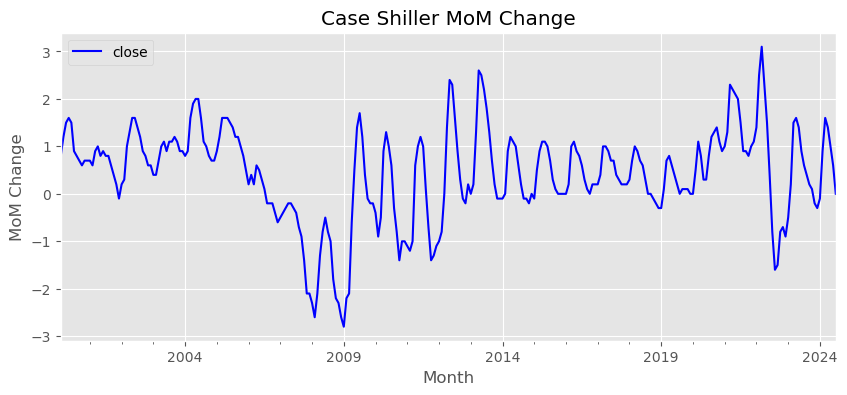

In [93]:
data.plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change")
plt.show()

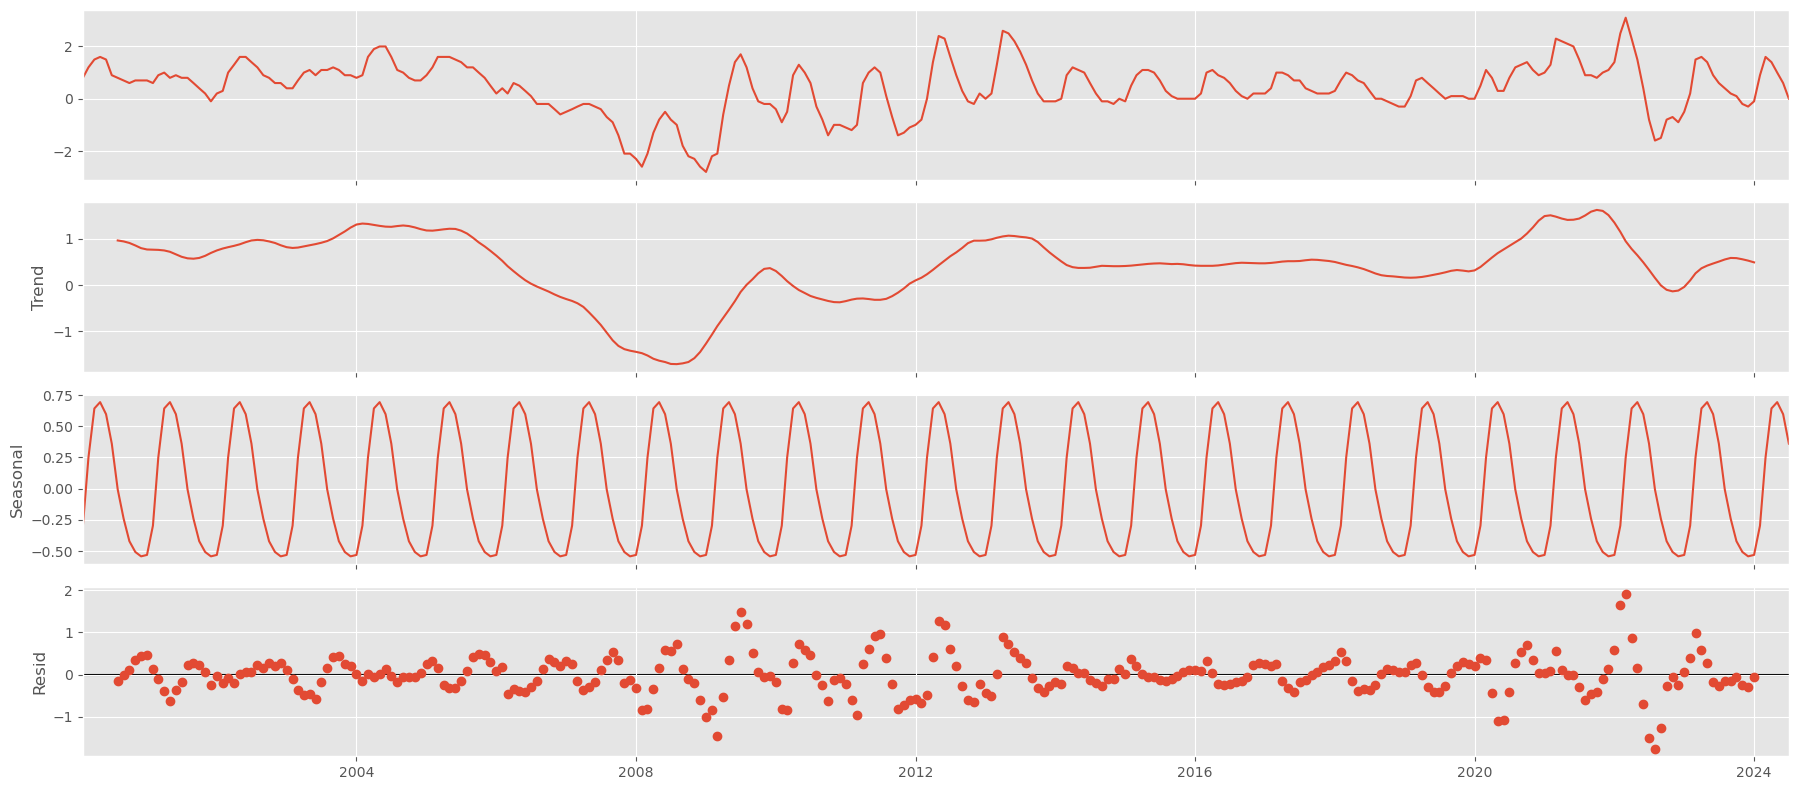

In [94]:
# Time-series decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

In [95]:
data_raw = np.array(data).reshape(-1,1)

In [96]:
# Normalize data to zero mean and unit variance
# scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
scaler = PowerTransformer()

data_scaled = scaler.fit_transform(data_raw)

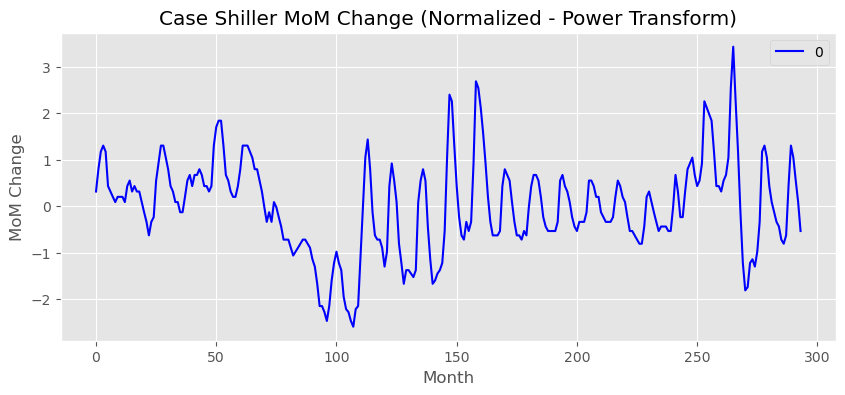

In [97]:
pd.DataFrame(data_scaled).plot(figsize=(10, 4),color='blue')
plt.xlabel("Month")
plt.ylabel('MoM Change')
plt.title("Case Shiller MoM Change (Normalized - Power Transform)")
plt.show()

In [99]:
data_scaled.shape

(294, 1)

In [110]:
# Split data using 3 years of data to predict
split = round(len(data)*.96)
number_targets = len(data) - split
data_targets = data.to_numpy()[split:]


train_data = data_scaled[:split]
test_data = data_scaled[split:]
print(train_data.shape)
print(test_data.shape)

(282, 1)
(12, 1)


In [120]:
# Parameters
n_input = number_targets
n_features = 1
batch_size = 10
epochs = 200

# Convert training data into sequences (sliding windows) needed for LSTM. each sequence of 12 the target is the next value, i.e. 13th.
def create_sequences(data, n_input):
    sequences = []
    for i in range(len(data) - n_input):
        seq = data[i:i + n_input]
        label = data[i + n_input]
        sequences.append((seq, label))
    return sequences

train_sequences = create_sequences(train_data, n_input)

# Convert to PyTorch tensors
train_x = torch.tensor([seq[0] for seq in train_sequences], dtype=torch.float32).to(device)
train_y = torch.tensor([seq[1] for seq in train_sequences], dtype=torch.float32).to(device)

## Create the model and train it - Vanilla LSTM

In [112]:
print(train_x.shape)
print(train_y.shape)

torch.Size([270, 12, 1])
torch.Size([270, 1])


In [121]:
# Dataset and DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a probability of 0.2
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        x = torch.relu(self.fc1(lstm_out[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [122]:
# Train the model
def train_model(model, train_loader, epochs):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


    for epoch in range(epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step(loss)
        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [61]:
# Make future predictions - run just once
# Initialize and train the model
# model = LSTMModel(n_input, n_features)
# model = model.to(device)
# train_model(model, train_loader, epochs)

# model.eval()
# pred_list = []
# batch = train_data[-n_input:].reshape((1, n_input, n_features))
# batch = torch.tensor(batch, dtype=torch.float32)

# with torch.no_grad():
#     for i in range(n_input):
#         pred = model(batch).item()
#         pred_list.append(pred)
#         batch = torch.cat((batch[:, 1:, :], torch.tensor([[[pred]]], dtype=torch.float32)), dim=1)

# # Inverse transform the predictions
# predicted_sales = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1))

# # Create a dataframe for predictions
# df_predict = pd.DataFrame(predicted_sales, index=data[-n_input:].index, columns=['Prediction'])
# print(df_predict)

In [18]:
# def reset_weights(model):
#     for layer in model.children():
#         if hasattr(layer, 'reset_parameters'):
#             layer.reset_parameters()

In [123]:
# Averaging over multiple runs (to keep the loop structure like in the original code)
n_runs = 3
store = np.zeros((n_input, n_runs))

for i in range(n_runs):
    #reset_weights(model)  # Reset the weights to random
    model = LSTMModel(n_input, n_features).to(device)
    train_model(model, train_loader, epochs)
    pred_list = []

    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model(batch).item()
            pred_list.append(pred)
           # Update the batch by appending the prediction and removing the first element
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)

    store[:, i] = scaler.inverse_transform(np.array(pred_list).reshape(-1, 1)).flatten()

# Averaging predictions
final_vanilla = np.mean(store, axis=1)

Epoch [25/200], Loss: 0.1897
Epoch [50/200], Loss: 0.1413
Epoch [75/200], Loss: 0.1514
Epoch [100/200], Loss: 0.0746
Epoch [125/200], Loss: 0.1407
Epoch [150/200], Loss: 0.1276
Epoch [175/200], Loss: 0.0645
Epoch [200/200], Loss: 0.0856
Epoch [25/200], Loss: 0.1955
Epoch [50/200], Loss: 0.2378
Epoch [75/200], Loss: 0.2057
Epoch [100/200], Loss: 0.1490
Epoch [125/200], Loss: 0.1742
Epoch [150/200], Loss: 0.1878
Epoch [175/200], Loss: 0.1729
Epoch [200/200], Loss: 0.1475
Epoch [25/200], Loss: 0.1796
Epoch [50/200], Loss: 0.2212
Epoch [75/200], Loss: 0.2045
Epoch [100/200], Loss: 0.1748
Epoch [125/200], Loss: 0.1922
Epoch [150/200], Loss: 0.2217
Epoch [175/200], Loss: 0.1444
Epoch [200/200], Loss: 0.1388


In [124]:
print(final_vanilla.shape)
print(final_vanilla)

(12,)
[ 0.21882937 -0.13652886 -0.37235392 -0.36535444 -0.21115325  0.14480412
  0.6630153   1.00475043  1.21840544  1.16383468  0.92915601  0.62493252]


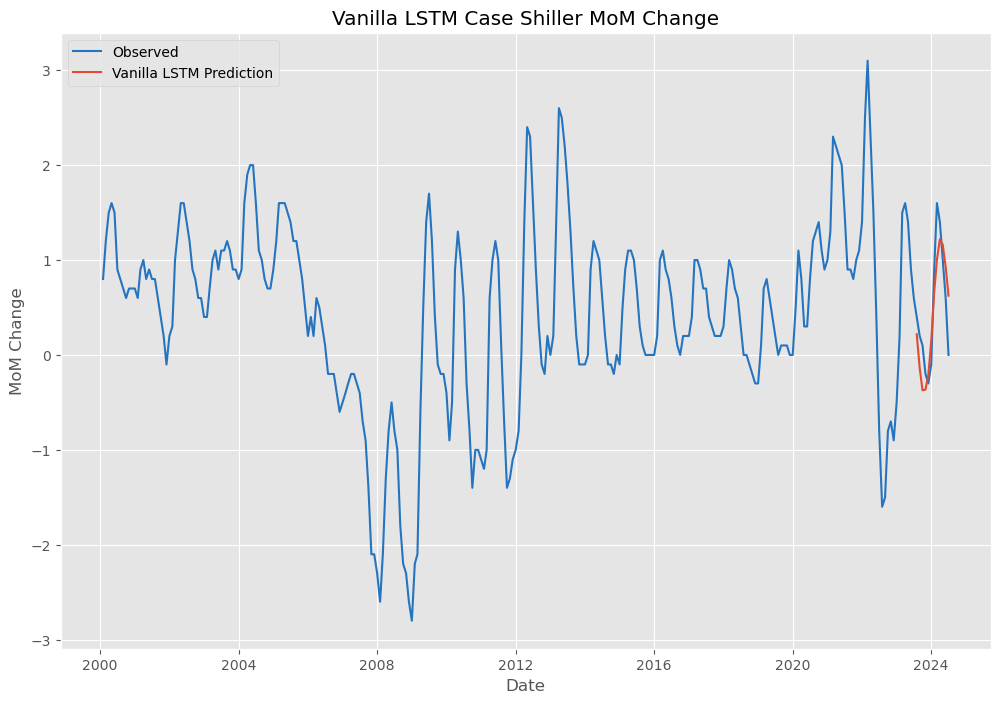

In [125]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM Case Shiller MoM Change')
plt.xlabel('Date')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [127]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / (y_true+0.001))) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

In [128]:
vanilla_lstm = performance(data_targets,final_vanilla)
vanilla_lstm

{'MSE': np.float64(0.7), 'RMSE': np.float64(0.84), 'MAPE': np.float64(5107.72)}

## Stacked LSTM


In [129]:
# Define the stacked LSTM model
class StackedLSTMModel(nn.Module):
    def __init__(self, n_input, n_features):
        super(StackedLSTMModel, self).__init__()
        # First LSTM layer (returns entire sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True, dropout=0.25 ,num_layers=2)
        # Second LSTM layer (returns entire sequences)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        #manual dropout
        self.dropout = nn.Dropout(0.2)
        # Fully connected layers
        self.fc1 = nn.Linear(50, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out2, _ = self.lstm2(lstm_out1)
        x = lstm_out2[:, -1, :]  # Get the last time step output
        #x = self.dropout(x)  # Apply dropout here
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [130]:
# Train and predict multiple times
n_runs = 3
store2 = np.zeros((number_targets, n_runs))

for i in range(n_runs):
    # Initialize the model
    model_stacked = StackedLSTMModel(n_input=n_input, n_features=n_features).to(device)
    
    # Train the model
    train_model(model_stacked, train_loader, epochs)
    
    # Make predictions
    pred_list_s = []
    batch = train_data[-n_input:].reshape((1, n_input, n_features))
    batch = torch.tensor(batch, dtype=torch.float32).to(device)

    with torch.no_grad():
        for j in range(n_input):
            pred = model_stacked(batch).item()  # Get prediction
            pred_list_s.append(pred)
            # Update the batch by appending the predicted value
            pred_tensor = torch.tensor([[[pred]]], dtype=torch.float32).to(device)  # Ensure pred is on device
            batch = torch.cat((batch[:, 1:, :], pred_tensor), dim=1)


    # Inverse transform the predictions and store them
    store2[:, i] = scaler.inverse_transform(np.array(pred_list_s).reshape(-1, 1)).flatten()

# Average the results across runs (if needed)
final_stacked = np.mean(store2, axis=1)
print(final_stacked)

Epoch [25/200], Loss: 0.1483
Epoch [50/200], Loss: 0.0982
Epoch [75/200], Loss: 0.0537
Epoch [100/200], Loss: 0.0203
Epoch [125/200], Loss: 0.0062
Epoch [150/200], Loss: 0.0049
Epoch [175/200], Loss: 0.0014
Epoch [200/200], Loss: 0.0011
Epoch [25/200], Loss: 0.0623
Epoch [50/200], Loss: 0.0215
Epoch [75/200], Loss: 0.0069
Epoch [100/200], Loss: 0.0027
Epoch [125/200], Loss: 0.0008
Epoch [150/200], Loss: 0.0002
Epoch [175/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001
Epoch [25/200], Loss: 0.1435
Epoch [50/200], Loss: 0.0342
Epoch [75/200], Loss: 0.0088
Epoch [100/200], Loss: 0.0018
Epoch [125/200], Loss: 0.0006
Epoch [150/200], Loss: 0.0004
Epoch [175/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0003
[0.30457995 0.25012759 0.65143523 1.27829191 1.68590734 1.95514008
 1.79082062 1.55660276 1.50755379 1.67946694 1.59318397 1.48232816]


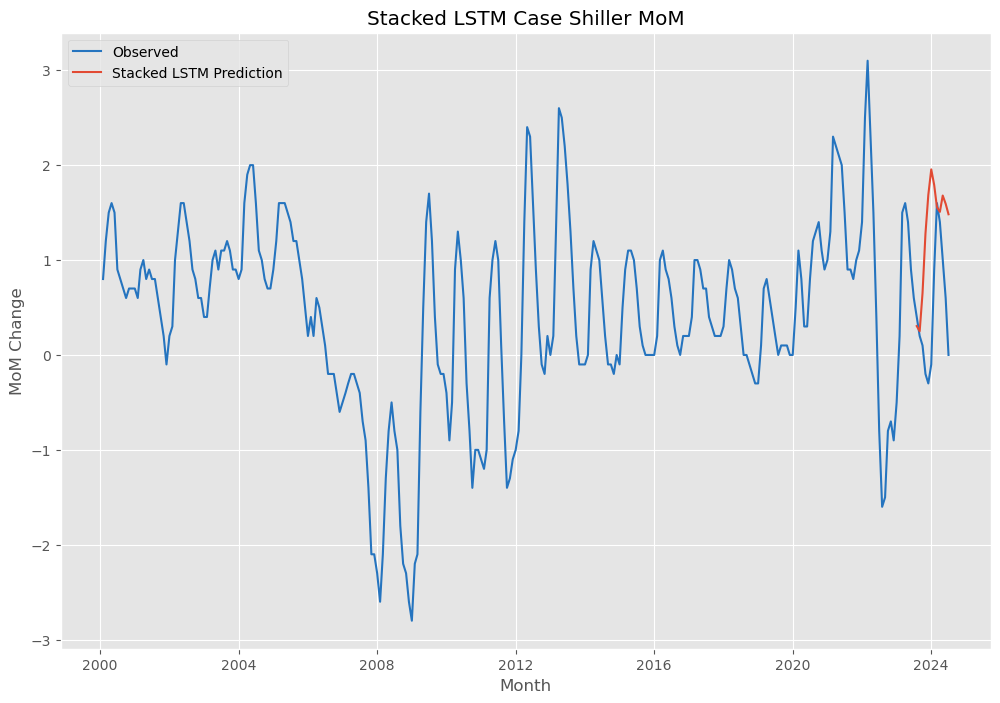

In [131]:
plt.plot(data.index,data,label="Observed",color='#2574BF')
plt.plot(data[split:].index,final_stacked,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM Case Shiller MoM')
plt.xlabel('Month')
plt.ylabel('MoM Change')
plt.legend()
plt.show()

In [132]:
stacked_lstm= performance(data_targets,final_stacked)
stacked_lstm

{'MSE': np.float64(1.39),
 'RMSE': np.float64(1.18),
 'MAPE': np.float64(11347.4)}